<a href="https://colab.research.google.com/github/Lunnaris01/BS/blob/master/exercises10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***
<p style="text-align:left;">Reinforcement Learning
<span style="float:right;">Monday, 29. June 2020</span></p>

<p style="text-align:left;">Prof. S. Harmeling
<span style="float:right;">DUE 23:55 Monday, 06. July 2020</span></p>

---
<p style="text-align:center;"><b>Exercise set #10</b></p>

---

# 1. Deep Q-Networks and Experience Replay

In  this  exercise  we  will  implement  components  of  a  well  known  reinforcement  learning paper, basically the algorithm described on page 5 in , ”Playing Atari with Deep Reinforcement Learning” (Mnih, Kavukcuoglu, Silver et.al.), see https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [1]:
import numpy as np
import gym
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from collections import deque

The following gym environment represents the maze from Figure 8.2 of Sutton and Barto.


In [2]:
class SimpleMazeEnv(gym.Env):

    def __init__(self, width=9, height=6):
        super().__init__()
        assert width >= 9 and height >= 6, "grid too small!"
        self.width = width
        self.height = height
        self.grid = np.zeros((self.width, self.height), dtype=np.uint8)

        self.observation_space = gym.spaces.Box(
            low=0, high=1,
            shape=self.grid.shape,
            dtype=self.grid.dtype)
        self.action_space = gym.spaces.Discrete(4)
        
        # Set up maze
        self.goal_init_pos = (self.width-1, 0)
        self.agent_init_pos = (0, 2)

        self.walls = np.zeros_like(self.grid)
        self.walls[2, 1:self.height-2] = 1
        self.walls[5, 4:self.height-1] = 1
        self.walls[self.width-2, 0:self.height-3] = 1

        self.reset()


    def reset(self):
        self.agent_pos = self.agent_init_pos
        self.goal_pos = self.goal_init_pos
        self.step_count = 0
        self.grid[:] = 0
        self.grid[self.agent_pos] = 1
        return self.grid

    def step(self, action):
        x, y = self.agent_pos
        w, h = self.grid.shape
        reward = 0.0
        done = False

        if action == 0:
            x += 1
        elif action == 1:
            y += 1
        elif action == 2:
            x -= 1
        elif action == 3:
            y -= 1
        else:
            raise ValueError("Invalid action")
            
        self.step_count += 1
        if 0 <= x < w and 0 <= y < h and not self.walls[x, y]:
            self.grid[self.agent_pos] = 0
            self.agent_pos = (x, y)
            self.grid[self.agent_pos] = 1
            if (x, y) == self.goal_pos:
                reward = 1.0
                done = True
        return self.grid, reward, done, {}

It has four actions (up, down, left, right) and the observation is the one-hot encoded position of the agent.
The reward is one if the goal tile is reached, in which case the episode ends. Otherwise the reward is zero.

In [3]:
env = SimpleMazeEnv()
print('Action space:', env.action_space)
print('Obersvation space:', env.observation_space)

Action space: Discrete(4)
Obersvation space: Box(9, 6)


Please use PyTorch for this exercise.  
If it is availabe to you, you can use CUDA.

In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using device:', DEVICE)
if torch.cuda.is_available():
  torch.set_default_tensor_type('torch.cuda.FloatTensor')

using device: cuda


## Deep Q-learning

Your first task is to implement Deep Q-learning (that means simple Q-learning where the action-value function is approximated by a "deep" neural network) without experience replay.

We want to keep the implementaion as general as reasonably possible and will therefore work with states as described in Section 2 of the paper, i.e. for each timestep $t$ the state $s_t$ is a sequence of the actions $a_i$ and observations $x_i$ up until that point:  
$s_t = (x_1, a_1, x_2, \cdots, a_{t-1}, x_t)$

You need to write a function to preprocess the sequence $s_t$ into something better suited to be used as a neural network input. You really only need to use the last element of $s_t$ (this is the last observation $x_t$) and put it into a PyTorch tensor with appropriate dtype on the correct device.  
However, your preprocessing function may also stack the last few observations together, normalize the observations, reduce dimensionality or do a myriad of other things!

In [5]:
def preprocess(s):
    phi = s[-1]
    phi = phi.reshape(-1)
    return torch.tensor(phi).float()

Now define your network. We hope that you will experiment with a variety of architectures, but please include only one network in your submission. Also, try to keep the network small.

In [6]:
class DQN(torch.nn.Module):
  def __init__(self,D_in, H,D_out):
    super(DQN,self).__init__()
    self.l1 = nn.Linear(D_in,H)
    #self.l2 = nn.Linear(448,512)
    self.out = nn.Linear(H,D_out)

  def forward(self, x):
    h_1 = self.l1(torch.flatten(x))
    #h_2 = self.l2(h_1)
    q_vals = self.out(h_1)
    return q_vals


Implement the loss function described on page 5 of the paper. This should work with a whole batch of replays at once, so you will be able to reuse this function in the later parts of this exercise.

In [7]:
def loss_fn(Q, old_phis, actions, rewards, phis, dones, gamma):
    with torch.no_grad():
      Q_new = Q.forward(phis)
    Q_olds = Q.forward(old_phis)
    Q_old = Q_olds.gather(-1,actions)
    y = rewards+(~dones)*gamma*torch.max(Q_new)
    losscrit = torch.nn.MSELoss(reduction='mean')
    loss = losscrit(Q_old,y.unsqueeze(0))
    return loss

Once again implement a function to choose an action epsilon-greedily. The only difference to previous exercises is that this function has to work with PyTorch.

In [8]:
def epsilon_greedy_action(env, Q, epsilon, phi):
  if np.random.random_sample()<epsilon:
    return env.action_space.sample()
  with torch.no_grad():
    Q_val = Q.forward(torch.as_tensor(phi).float())
    action = torch.argmax(Q_val).cpu().numpy()
    return action
    

Implement the rest of the deep Q-learning. As usual you have to fill out the designated places in the code, but feel free to write helper functions outside of the `train_deepq` function.

In [9]:
def next_replay_tuple(env, Q, s, phi, epsilon):
    act = epsilon_greedy_action(env, Q, epsilon, phi)
    x, r, done, _ = env.step(act)
    phi_old = phi
    s += (act, x)
    phi = preprocess(s)
    replay_tuple = (
        phi_old,
        torch.tensor(act, device=DEVICE),
        torch.tensor(r, device=DEVICE),
        phi,
        torch.tensor(done, device=DEVICE)
    )
    return s, replay_tuple

In [10]:
def opt_step(model, optimizer, replays, gamma):
    model.train()
    optimizer.zero_grad()
    loss = loss_fn(model, *replays, gamma)
    loss.backward()
    optimizer.step()

In [11]:
def train_deepq(
    env,
    Q,
    optimizer,
    num_episodes=50,
    epsilon_max=1.0,
    epsilon_min=0.1,
    epsilon_decay=0.95,
    gamma=0.95,
    silent=False):
    """Train a neural network using Q-learning.
    
    Args:
        env: The environment to train on
        Q: A PyTorch module, the network that will
        approximate the action-value function
        optimizer: The PyTorch optimizer to use
        ...
        
    Returns:
        steps: Array containing number of steps per episode
    """

    epsilon = epsilon_max
    steps = []

    for i in range(num_episodes):
        #########################
        # Write your code here. #
        #########################
        s = (env.reset(),)
        done = False
        while not done and env.step_count<10000:
          s, replay_tuple = next_replay_tuple(env,Q,s,preprocess(s),epsilon)
          opt_step(Q,optimizer,replay_tuple,gamma)
          _,_,_,_,d = replay_tuple
          done = d.cpu().numpy()
        steps.append(env.step_count)
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        if not silent:
            print("\rEpisode {} took {} steps, epsilon {}   ".format(i+1, env.step_count, epsilon), flush=True, end='')
    return np.array(steps)

In [12]:
D_in = env.observation_space.shape[0]*env.observation_space.shape[1]
H= 256
D_out = env.action_space.n

learning_rates = [1e-3,5e-4,1e-4]

Test your implementation and explore the effect of different hyperparameters.  
Choose at least two settings for hyperparameters and plot the respective learning curves.
The learning curve is given by the step count per episode during training. Train for at least 50 episodes and average the step counts over at least 5 different training runs.

In [13]:
#########################
# Write your code here. #
#########################

avglist_noreplay =[]
for lr in learning_rates:
  for i in range(1,6):
    print("Run " + str(i) + " for lr: " + str(lr))
    Q=DQN(D_in,H,D_out)
    avglist_noreplay.append(train_deepq(env,Q,torch.optim.Adam(Q.parameters(), lr=lr),silent=True))



Run 1 for lr: 0.001


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Run 2 for lr: 0.001
Run 3 for lr: 0.001
Run 4 for lr: 0.001
Run 5 for lr: 0.001
Run 1 for lr: 0.0005
Run 2 for lr: 0.0005
Run 3 for lr: 0.0005
Run 4 for lr: 0.0005
Run 5 for lr: 0.0005
Run 1 for lr: 0.0001
Run 2 for lr: 0.0001
Run 3 for lr: 0.0001
Run 4 for lr: 0.0001
Run 5 for lr: 0.0001


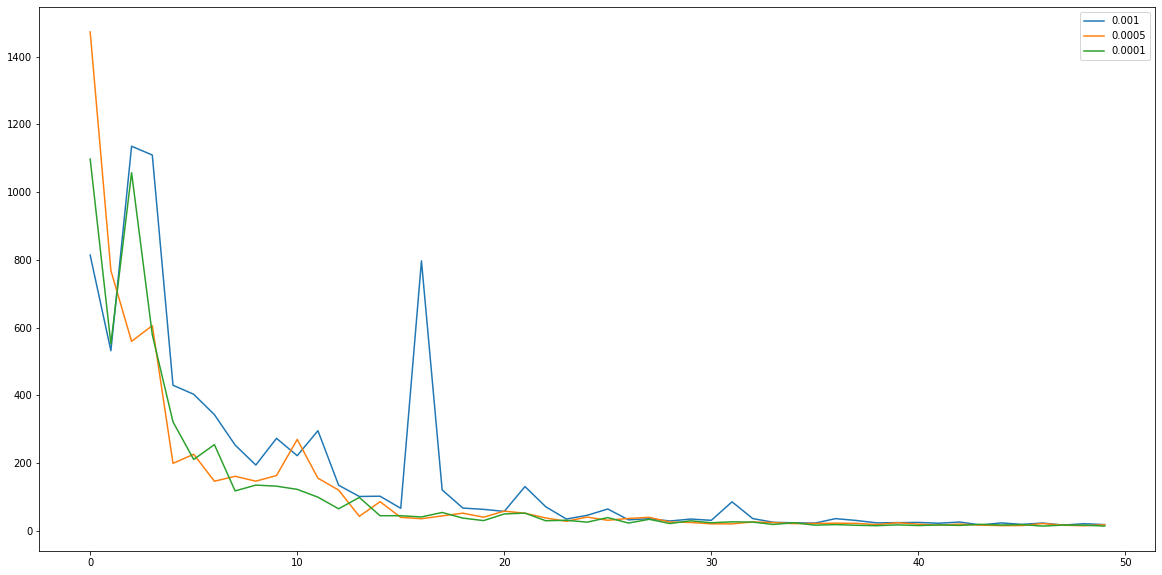

In [14]:
avg_noreplay = [np.mean(avglist_noreplay[5*i:5*(i+1)],axis=0) for i in range(len(learning_rates))]
fig = plt.figure(figsize=(20,10))
for i,lr in enumerate(learning_rates):
  plt.plot(avg_noreplay[i],label=lr)
plt.legend()

## Experience Replay

Now implement experience replay for your network on the gridworld.  
The basic idea is to save the agent's past experiences into some memory buffer and sample from hat during  training.  This should help, since the agent will always improve on some already seen experiences. For the buffer you will have to store past tuples of (state,action,reward,next-states), which means that one new hyperparameter will be the buffer size.

In [25]:
class ReplayBuffer(object):

    def __init__(self, size):
        self.memory_max_size = size
        self.memory = deque(maxlen=self.memory_max_size)
        self.counter = 0

    def append(self, transition):
        if len(self.memory) >= self.memory_max_size:
            self.memory.popleft()
        self.memory.append(transition)
        self.counter = self.counter+1

    def sample(self,batch_size):
      sample = random.sample(list(self.memory),batch_size)
      return sample

    def canSample(self,batch_size):
      if len(self.memory)>batch_size:
        return True
      return False


def train_deepq_experience_replay(
    env,
    Q,
    optimizer,
    num_episodes=50,
    epsilon_max=1.0,
    epsilon_min=0.1,
    epsilon_decay=0.95,
    gamma=0.95,
    batch_size=32,
    buffer_size=512,
    silent=False):
    """Train a neural network using Q-learning with experience replay.
    
    Args:
        env: The environment to train on
        Q: A PyTorch module, the network that will
        approximate the action-value function
        optimizer: The PyTorch optimizer to use
        ...
        
    Returns:
        steps: Array containing number of steps per episode
    """

    epsilon = epsilon_max
    steps = []

    # Choose a suitable data structure for the replay memory
    # and initialize it
    #########################
    # Write your code here. #
    #########################
    Buffer = ReplayBuffer(buffer_size)

    for i in range(num_episodes):
        #########################
        # Write your code here. #
        #########################
        s = (env.reset(),)
        done = False

        while not done and env.step_count<10000:
          s, replay_tuple = next_replay_tuple(env,Q,s,preprocess(s),epsilon)
          opt_step(Q,optimizer,replay_tuple,gamma)
          Buffer.append(replay_tuple)
          _,_,_,_,d = replay_tuple
          done = d.cpu().numpy()
          if Buffer.canSample(batch_size):
            replay_tuples = Buffer.sample(batch_size)


        steps.append(env.step_count)
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        if not silent:
            print("\rEpisode {} took {} steps, epsilon {}   ".format(i+1, env.step_count, epsilon), flush=True, end='')
    return np.array(steps)

Does experience replay help? How strong is the effect on the buffer size? Do you need to modify other hyperparameters?  
To answer that, produce learning curves for varying hyperparameters of interest.

In [26]:
avglist_replay =[]
for lr in learning_rates:
  for i in range(1,6):
    print("Run " + str(i) + " for lr: " + str(lr))
    Q=DQN(D_in,H,D_out)
    avglist_replay.append(train_deepq_experience_replay(env,Q,torch.optim.Adam(Q.parameters(), lr=lr),silent=True))

Run 1 for lr: 0.001


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Run 2 for lr: 0.001
Run 3 for lr: 0.001
Run 4 for lr: 0.001
Run 5 for lr: 0.001
Run 1 for lr: 0.0005
Run 2 for lr: 0.0005
Run 3 for lr: 0.0005
Run 4 for lr: 0.0005
Run 5 for lr: 0.0005
Run 1 for lr: 0.0001
Run 2 for lr: 0.0001
Run 3 for lr: 0.0001
Run 4 for lr: 0.0001
Run 5 for lr: 0.0001


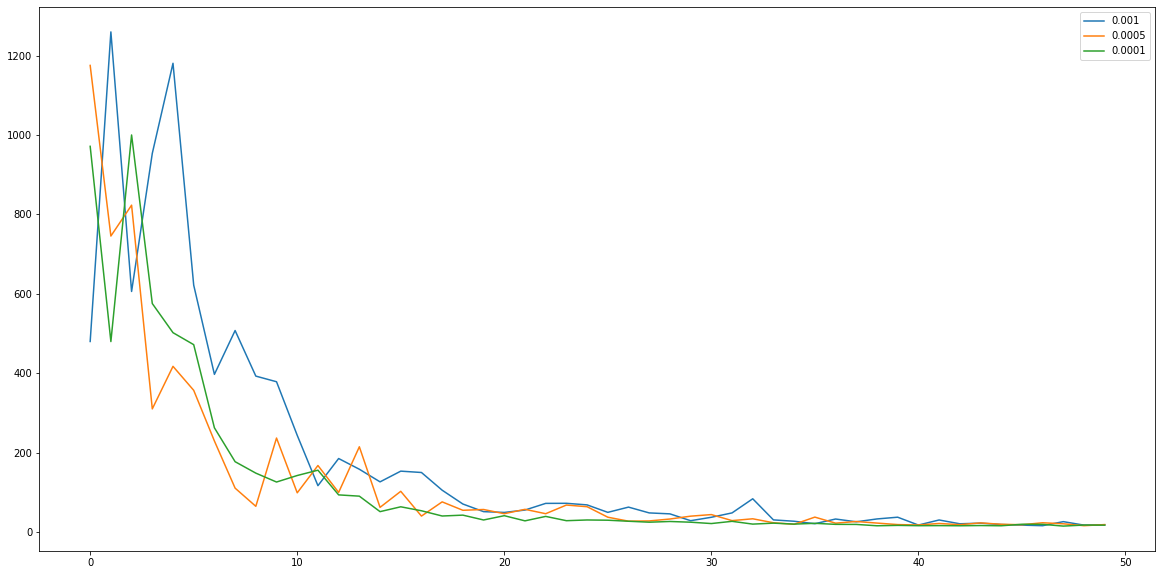

In [27]:
avg_replay = [np.mean(avglist_replay[5*i:5*(i+1)],axis=0) for i in range(len(learning_rates))]
fig = plt.figure(figsize=(20,10))
for i,lr in enumerate(learning_rates):
  plt.plot(avg_replay[i],label=lr)
plt.legend()

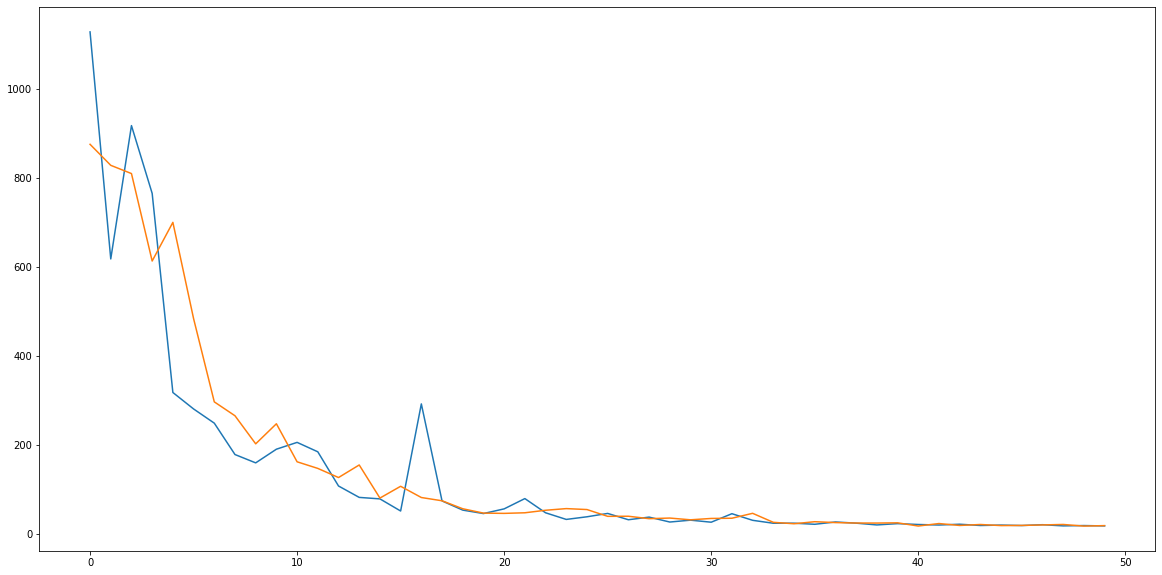

In [28]:
avg_alllr_noreplay = np.mean(avg_noreplay,axis=0)
avg_alllr_replay = np.mean(avg_replay,axis=0)

fig = plt.figure(figsize=(20,10))
plt.plot(avg_alllr_noreplay,label = "No Replay")
plt.plot(avg_alllr_replay,label = "Replay")

## Generalization

Change the environment (e.g. set width and height in `SimpleMazeEnv` to be slightly bigger than the standard 9x6, or write your own maze environment!) but use the same network as before. How good does your implementation perform now, can it reach the goal state? Do you need to adjust some of the hyperparameters?  
Plot the new learning curve.

In [38]:
env = SimpleMazeEnv(20,30)
print('Action space:', env.action_space)
print('Obersvation space:', env.observation_space)

D_in = env.observation_space.shape[0]*env.observation_space.shape[1]
H= 256
D_out = env.action_space.n


Action space: Discrete(4)
Obersvation space: Box(20, 30)


Run 1 for lr: 0.0001


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Run 2 for lr: 0.0001
Run 3 for lr: 0.0001
Run 4 for lr: 0.0001
Run 5 for lr: 0.0001


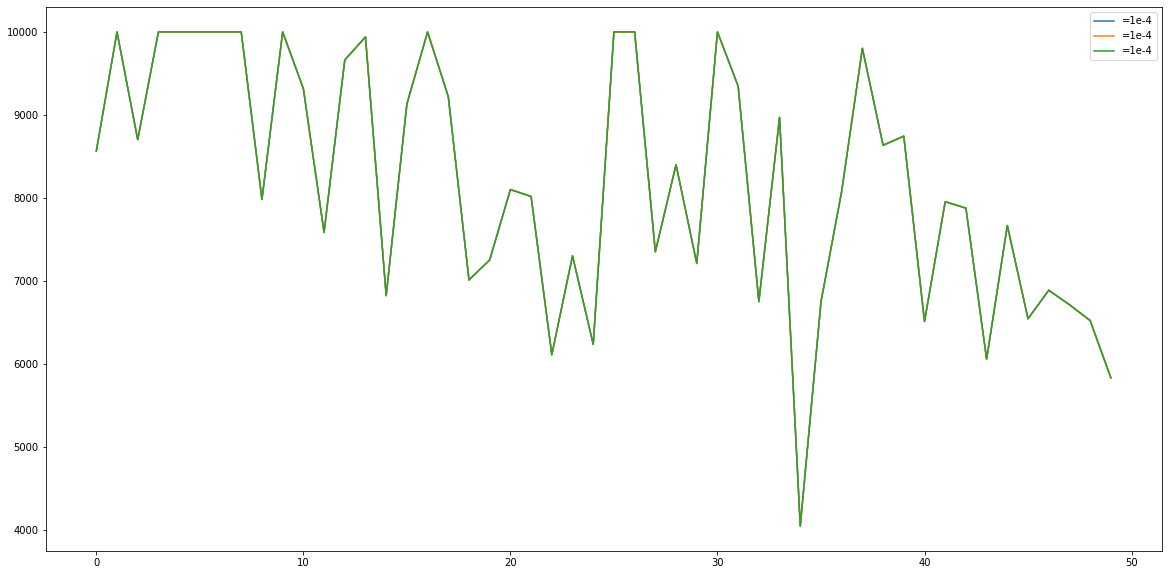

In [39]:
stepscomplex =[]
fig = plt.figure(figsize=(20,10))
for i in range(1,6):
  print("Run " + str(i) + " for lr: " + str(1e-4))
  Q=DQN(D_in,H,D_out)
  stepscomplex.append(train_deepq_experience_replay(env,Q,torch.optim.Adam(Q.parameters(), lr=1e-4),silent=True))

for i,lr in enumerate(learning_rates):
  plt.plot(np.mean(stepscomplex,axis=0),label="=1e-4")
plt.legend()

For the Environment used, no significant difference from DQN with and without replay was observed. Our net was pretty slow for the bigger environment, Probably because the goal was really hard to reach when the epsilon value was still very high. Steps were limited to 10.000 per episode here. DQN doesn't seem to work too well on environments with extremely sparse rewards, at least not for the presented maze, however some learning effect could be seen.